# 1 SETUP
***
Nesta seção serão realizadas:
- Importação das bibliotecas necessárias para análise;
- Definição de funções auxiliares que serão utilizadas ao longo do projeto;
- Configurações de padronização visual (gráficos, estilo, tamanhos, etc.).

In [64]:
# Data Analysis
import pandas as pd
import numpy as np

# DataViz 
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical
from scipy.stats import chi2_contingency

# Notebook Config 
import sys
import os
proj_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(proj_root)

# My Functions
from src.utils import df_summary_with_fraud, low_importance_numerical

In [63]:
from importlib import reload
import src.utils
reload(src.utils)

<module 'src.utils' from '/Users/matschualtz/Desktop/DataScience/Repositorios/Anomaly_Detection_4BankFraud/src/utils.py'>

In [58]:
df_trans = pd.read_csv('../data/raw/train_transaction.csv')
df_id = pd.read_csv('../data/raw/train_identity.csv')

# 2 BUSINESS UNDERSTANDING
***

ESCREVER A COMPREENSÃO DO PROBLEMA DE NEGÓCIO

# 3 DATA UNDERSTANDING
***
Nesta seção será realizada a compreensão inicial dos dados disponíveis. O objetivo é:
- Observar a estrutura do dataset, tipos de variáveis e dimensões;
- Identificar valores ausentes, duplicatas e possíveis inconsistências;
- Analisar distribuições e estatísticas básicas das variáveis;
- Explorar relações iniciais entre variáveis e com a variável alvo (quando aplicável);
- Gerar insights preliminares que orientarão a limpeza, transformação e modelagem dos dados

In [4]:
print(df_trans.head())
print(df_id.head())

   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  514.0  150.0  mastercard  102.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   

  V336  V337  V338  V339  
0  NaN   NaN   NaN   NaN  
1  NaN   NaN   NaN  

In [5]:
print(f'Transactions: {df_trans.shape}')
print(f'Identity: {df_id.shape}')

Transactions: (590540, 394)
Identity: (144233, 41)


## 3.1 DATA TRANSACTION
***
Entendimento dos dados de transação.

### 3.1.1 COLUNAS COM DADOS NULOS EM EXCESSO E NÃO ASSOCIADOS A FRAUDE
***

In [6]:
df_trans_analysis = df_summary_with_fraud(df_trans,'isFraud',id_cols_slice=slice(3,394))
DROP_COLUMNS_TRANS = df_trans_analysis[(df_trans_analysis['P-value'] > 0.05) & (df_trans_analysis['Data Null (P%)'] > 0)]['Data Name'].to_list()

### 3.1.2 VARIÁVEIS COM ALTA CORRELAÇÃO
***

In [7]:
cols_to_keep = [c for c in df_trans.columns[3:394] if c not in DROP_COLUMNS_TRANS]

corr_matrix = df_trans[cols_to_keep].corr(numeric_only=True).abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr = [(i, j, upper.loc[i, j])
             for i in upper.columns
             for j in upper.columns
             if not pd.isna(upper.loc[i, j]) and upper.loc[i, j] > 0.7]
high_corr = sorted(high_corr, key=lambda x: -x[2])


In [8]:
for col1, col2, corr in high_corr:
    if col1 in DROP_COLUMNS_TRANS or col2 in DROP_COLUMNS_TRANS:
        continue  
    null1 = df_trans_analysis.loc[df_trans_analysis['Data Name'] == col1, 'Data Null (P%)'].values[0]
    null2 = df_trans_analysis.loc[df_trans_analysis['Data Name'] == col2, 'Data Null (P%)'].values[0]

    if null1 > null2:
        DROP_COLUMNS_TRANS.append(col1)
    else:
        DROP_COLUMNS_TRANS.append(col2)

Durante o processo de seleção de variáveis, foram aplicados testes de associação (qui-quadrado de contingência) e análise de correlação, resultando em um conjunto de variáveis candidatas à remoção. Entretanto, reconhece-se que esse procedimento pode levar à exclusão equivocada de variáveis categóricas, que, embora apresentem redundância estatística, possuem relevância prática.

Por esse motivo, todas as variáveis categóricas sinalizadas para exclusão serão reavaliadas, e caso seja identificado que uma variável contém informação potencialmente útil, ela será preservada e removida da lista de exclusão, garantindo que não haja perda de sinais relevantes para o modelo.

In [26]:
df_trans[DROP_COLUMNS_TRANS].select_dtypes(include=['object', 'category','datetime64'])

,card4
0,discover
1,mastercard
2,visa
3,mastercard
4,mastercard
...,...
590535,visa
590536,mastercard
590537,mastercard
590538,mastercard


Ao consultar o dicionário de dados, observou-se que a variável card4, em conjunto com outras variáveis relacionadas ao cartão, pode carregar padrões relevantes sobre o comportamento das transações. Por esse motivo, a variável será preservada e avaliada com maior rigor durante a etapa de pré-processamento, a fim de verificar seu real potencial explicativo para o modelo.

In [33]:
df_trans[['card1','card2','card3','card4','card5','card6']]
DROP_COLUMNS_TRANS.remove('card4')

### 3.1.3 FEATURE IMPORTANCE
***

A fim de garantir uma seleção eficaz, será aplicado um processo de remoção prévia de variáveis com base em técnicas de feature importance. Esse procedimento é fundamental para melhorar a qualidade do modelo preditivo, pois permite reduzir a dimensionalidade, eliminar redundâncias e priorizar variáveis que de fato contribuem para a explicação da variável alvo.

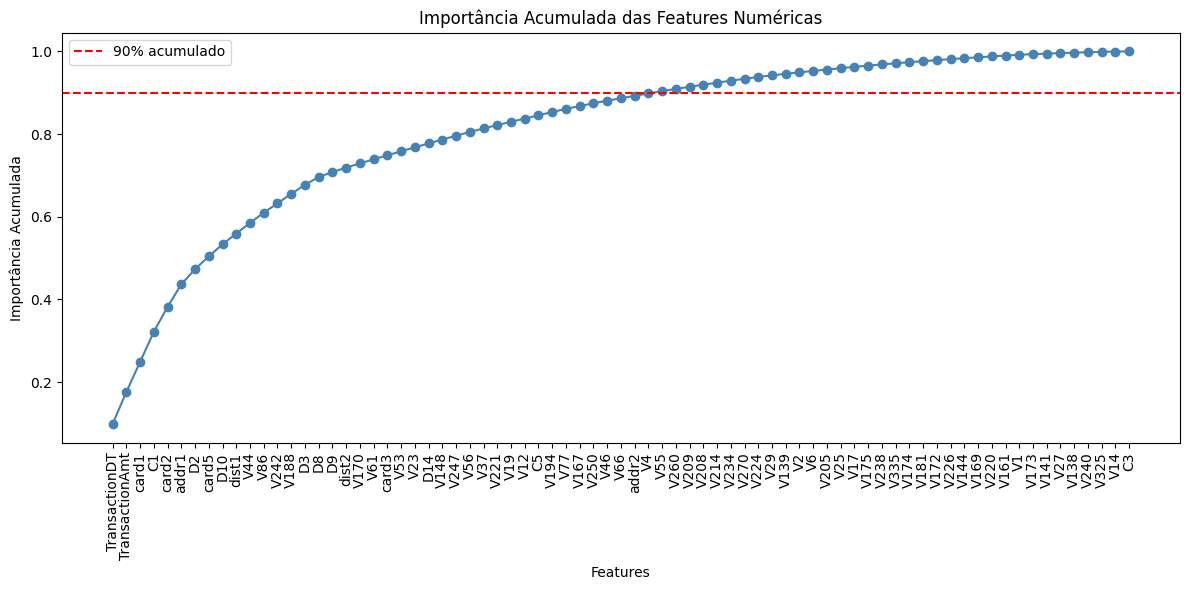

,Feature,Importance,cumulative_importance,contribution
0,TransactionDT,0.098801,0.098801,0.098801
1,TransactionAmt,0.077236,0.176037,0.077236
2,card1,0.072994,0.249031,0.072994
3,C1,0.072632,0.321663,0.072632
4,card2,0.060444,0.382107,0.060444
...,...,...,...,...
70,V138,0.001087,0.997061,0.001087
71,V240,0.000972,0.998033,0.000972
72,V325,0.000943,0.998976,0.000943
73,V14,0.000854,0.999830,0.000854


In [67]:
cols_to_keep = [c for c in df_trans.columns[1:394] if c not in DROP_COLUMNS_TRANS]

low_num_cols, cumulative_importance = low_importance_numerical(df_trans[cols_to_keep], target_col='isFraud', threshold=0.001)
cumulative_importance

## 3.2 DATA IDENTITY
***
Entendimento dos dados de identificação. Para melhor compreensão será concatenado os dados de identificação para que seja possível ter os targets das transações fraudulentas.

In [65]:
target = df_trans[['TransactionID','isFraud']]
df_id = df_id.merge(target, how='left', on='TransactionID')

### 3.2.1 COLUNAS COM DADOS NULOS ASSOCIADAS A FRAUDE
***

In [ ]:
df_id_analysis = df_summary_with_fraud(df_id,'isFraud',id_cols_slice=slice(1,41))

# Colunas para remover por nao possuir relação direta com fraude 

DROP_COLUMNS_ID = df_id_analysis[df_id_analysis['P-value'] > 0.05]['Data Name'].to_list()

### 3.2.2 COLUNAS COM ALTA CORRELAÇÃO
***

<Axes: >

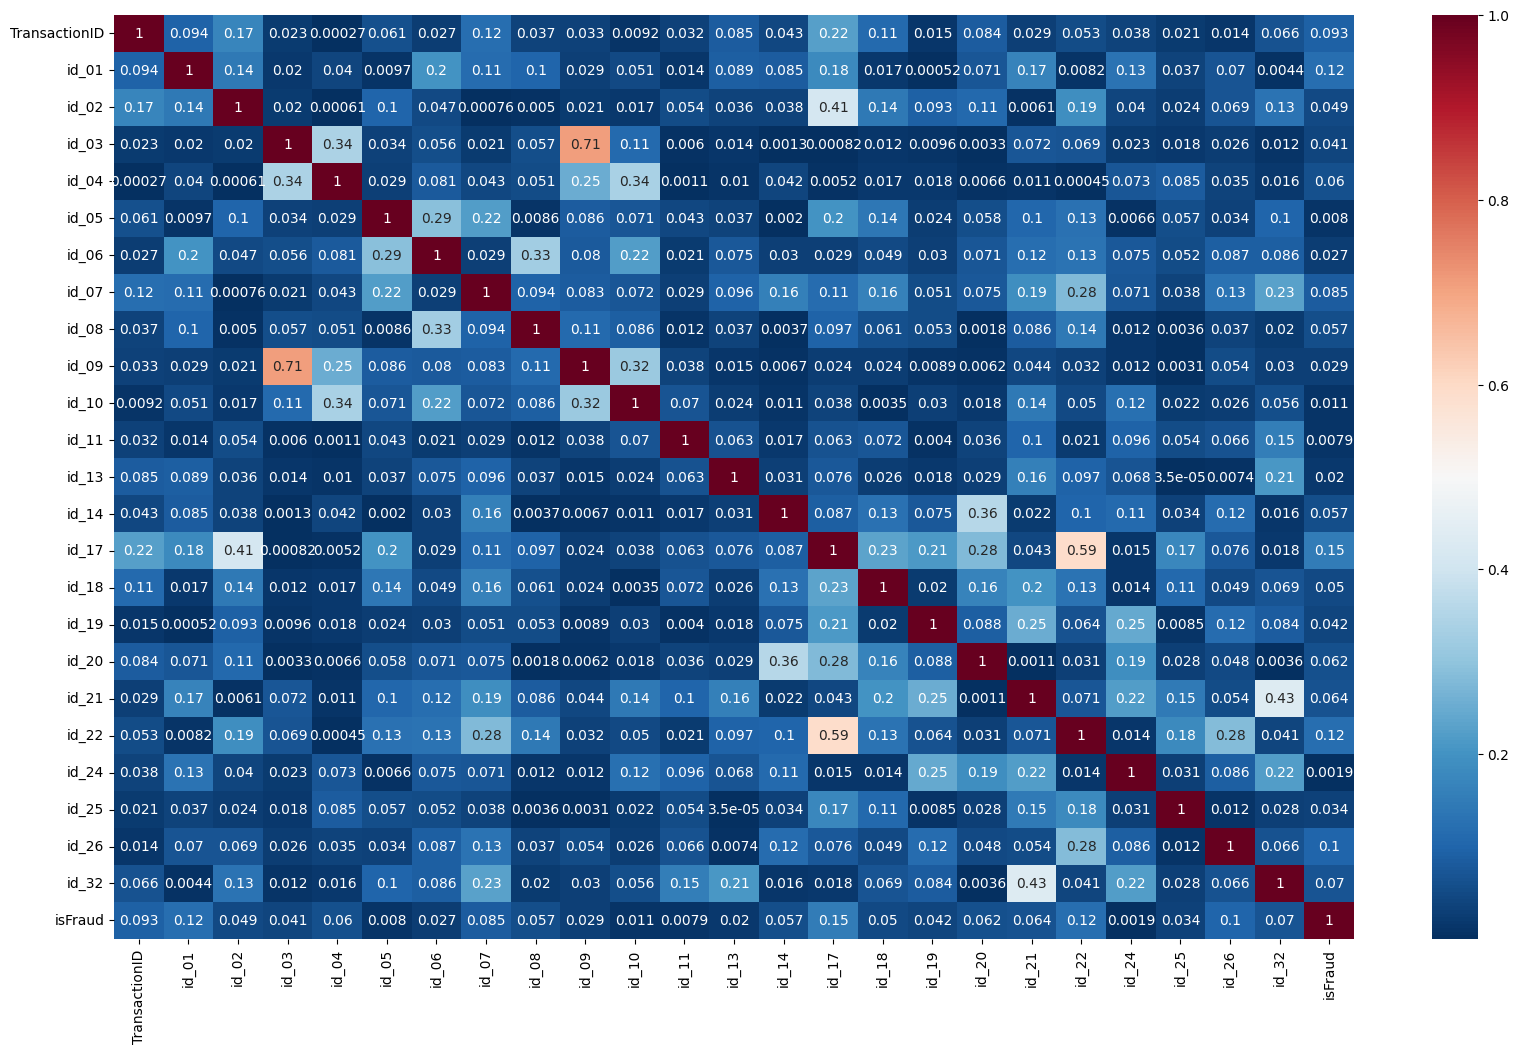

In [11]:
corr_matrix = df_id.corr(numeric_only=True).abs()
high_corr = [(i,j) for i in corr_matrix.columns for j in corr_matrix.columns 
             if i != j and corr_matrix.loc[i,j] > 0.5]
plt.figure(figsize=(20,12))
sns.heatmap(corr_matrix, annot=True,fmt='.2g',cmap='RdBu_r')

In [12]:
for tupla in high_corr:
    for value in tupla:
        if value in DROP_COLUMNS_ID:
            print(f'Coluna {value} já está mapeada')

Coluna id_22 já está mapeada
Coluna id_22 já está mapeada


In [13]:
df_id_analysis[df_id_analysis['Data Name'].isin(('id_03', 'id_09'))]

,Data Name,Data Type,Data Null (A),Data Null (P%),Fraud Rate Null,Fraud Rate Not Null,P-value
2,id_03,float64,77909,54.016071,0.053986,0.107231,3.109065e-307
8,id_09,float64,69307,48.052110,0.050370,0.104463,0.000000e+00


Como a coluna id_22 já foi mapeada para exclusão anteriormente, a coluna id_17 será mantida. Já para a correlação encontrada entre a coluna id_03 e id_09 será removida a coluna id_03, por possuir um percentual maior de nulos em relação a id_09.

In [14]:
DROP_COLUMNS_ID.append('id_03')

### 3.2.3 FEATURE IMPORTANCE
***

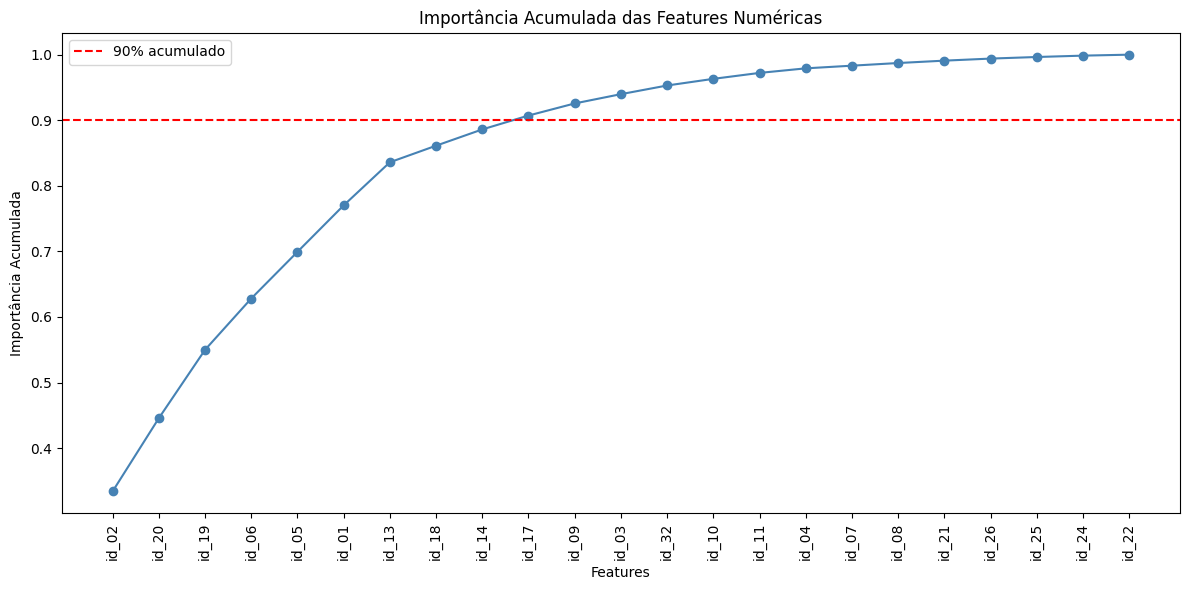

,Feature,Importance,cumulative_importance,contribution
0,id_02,0.333973,0.333973,0.333973
1,id_20,0.111588,0.445561,0.111588
2,id_19,0.104296,0.549857,0.104296
3,id_06,0.078247,0.628104,0.078247
4,id_05,0.071164,0.699268,0.071164
5,id_01,0.070864,0.770133,0.070864
6,id_13,0.065765,0.835897,0.065765
7,id_18,0.025284,0.861181,0.025284
8,id_14,0.024817,0.885998,0.024817
9,id_17,0.021152,0.907150,0.021152


In [66]:
low_num_cols, cumulative_importance = low_importance_numerical(df_id, target_col='isFraud', threshold=0.001)
cumulative_importance

In [16]:
feature_importance = cumulative_importance[cumulative_importance['Importance'] > 0.90]['CleanFeature'].to_list()

for value in feature_importance:
    if value in DROP_COLUMNS_ID:
        print(f'Coluna {value} já está mapeada')
    else:
        print(f'Coluna {value} adicionada para remoção')
        DROP_COLUMNS_ID.append(value)

Coluna id_17 adicionada para remoção
Coluna id_09 adicionada para remoção
Coluna id_03 já está mapeada
Coluna id_32 adicionada para remoção
Coluna id_10 adicionada para remoção
Coluna id_11 adicionada para remoção
Coluna id_04 adicionada para remoção
Coluna id_07 já está mapeada
Coluna id_08 já está mapeada
Coluna id_21 já está mapeada
Coluna id_26 já está mapeada
Coluna id_25 já está mapeada
Coluna id_24 já está mapeada
Coluna id_22 já está mapeada


Por fim, será realizada a mesma verificação no dataframe df_trans, avaliando variáveis categóricas que podem conter padrões relevantes e que requerem uma exploração mais cuidadosa.

In [ ]:
df_id[DROP_COLUMNS_ID].select_dtypes(include=['object', 'category'])

,id_27,id_23,id_16,id_12
0,NaN,NaN,NotFound,NotFound
1,NaN,NaN,NotFound,NotFound
2,NaN,NaN,Found,NotFound
3,NaN,NaN,NotFound,NotFound
4,NaN,NaN,Found,NotFound
...,...,...,...,...
144228,NaN,NaN,Found,NotFound
144229,NaN,NaN,NotFound,NotFound
144230,NaN,NaN,NotFound,NotFound
144231,NaN,NaN,Found,NotFound


Nesse caso, as variáveis não apresentam informação relevante para o modelo e, portanto, podem ser removidas.

### 4 FINAL DROP COLUMNS 
***

In [36]:
print('Colunas para remoção DF Transaction')
print(DROP_COLUMNS_TRANS)
print('*'*170)
print('Colunas para remoção DF Identity')
print(DROP_COLUMNS_ID)

Colunas para remoção DF Transaction
['V315', 'V281', 'V282', 'V314', 'V313', 'V301', 'V288', 'D1', 'V289', 'V300', 'V296', 'V283', 'V131', 'V132', 'V128', 'V118', 'V119', 'V133', 'V134', 'V136', 'V137', 'V130', 'V129', 'V127', 'V116', 'V126', 'V120', 'V125', 'V124', 'V95', 'V121', 'V122', 'V123', 'V117', 'V135', 'V115', 'V105', 'V99', 'V100', 'V101', 'V102', 'V114', 'V97', 'V96', 'V103', 'V98', 'V104', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V308', 'V307', 'V309', 'V310', 'V311', 'V318', 'V312', 'V316', 'V317', 'V319', 'V320', 'V321', 'V305', 'V306', 'V294', 'V304', 'V291', 'V279', 'V285', 'V286', 'V287', 'V280', 'V290', 'V292', 'V284', 'V293', 'V295', 'V297', 'V298', 'V299', 'V302', 'V303', 'D12', 'C12', 'V177', 'V211', 'C10', 'V164', 'C11', 'V269', 'V213', 'V231', 'C2', 'V179', 'V332', 'V233', 'V324', 'V322', 'V18', 'V276', 'V232', 'V182', 'V178', 'V202', 'V16', 'D7', 'V154', 'V333', 'V32', 'V331', 'V278', 'C14', 'V256', 'V251', 'V219', 'C8', 'V143', 'V212', 